# Main Regions

**Objective:**

Extract and preserve the most important structural details by detecting the top % brightest pixels from the FFT‑processed image, and generate a clean hybrid skeleton+bright mask to maintain design fidelity.

Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.morphology import binary_closing, binary_opening, disk, remove_small_objects
from skimage.morphology import medial_axis
from skimage.util import invert

# Load image

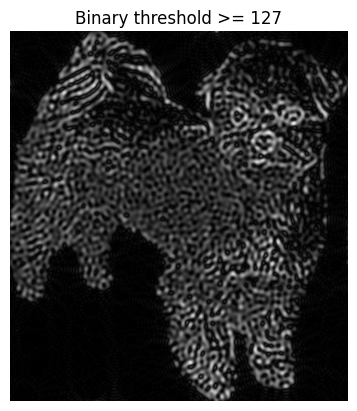

In [2]:
img_path = "/content/img_back.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')
plt.title("Binary threshold >= 127")
plt.axis('off')
plt.show()

# Generate Bright Mask

In [3]:
def generate_bright_mask(img, threshold_percentile=90):
    '''
    Generate a binary mask of the brightest regions in a grayscale image.
    '''
    if img.max() <= 1:
        img = (img * 255).astype(np.uint8)
    else:
        img = img.astype(np.uint8)

    flat_vals = img[img > 0].flatten()

    threshold_val = np.percentile(flat_vals, threshold_percentile)

    _, bright_mask = cv2.threshold(img, int(threshold_val), 1, cv2.THRESH_BINARY)
    bright_mask = (bright_mask > 0).astype(np.uint8)

    # Closing the holes
    bright_mask = binary_closing(bright_mask, disk(2))
    bright_mask = binary_opening(bright_mask, disk(2))
    bright_mask = remove_small_objects(bright_mask.astype(bool), min_size=200).astype(np.uint8)

    return bright_mask

In [4]:
brg_mask= generate_bright_mask(img, 90)

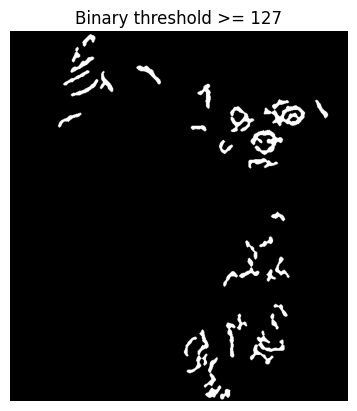

In [5]:
plt.imshow(brg_mask, cmap='gray')
plt.title("Binary threshold >= 127")
plt.axis('off')
plt.show()

# Skeleton Medial Axis

In [20]:
def medial_axis_skeleton(binary_image):
    """
    Compute skeleton preserving distance info using medial axis.
    Returns binary skeleton and distance map.
    """

    skel, dist = medial_axis(binary_image, return_distance=True)
    skel = skel.astype(np.uint8) * 255

    return skel


In [21]:
skeleton_ma=medial_axis_skeleton(brg_mask)

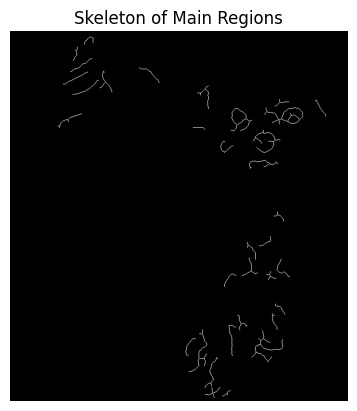

In [22]:
plt.imshow(skeleton_ma, cmap='gray')
plt.title("Skeleton of Main Regions")
plt.axis('off')
plt.show()

# Apply mask generated in preprocessing

In [23]:
mask_path = "/content/character_mask.png"

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

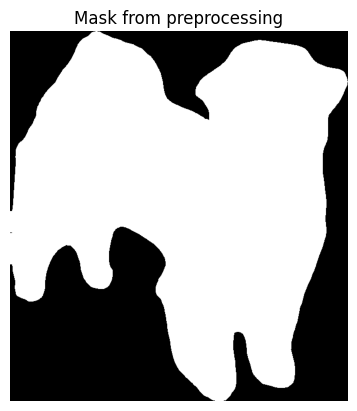

In [36]:
plt.imshow(mask, cmap='gray')
plt.title("Mask from preprocessing")
plt.axis('off')
plt.show()

In [37]:
def combine_axis_skeleton(mask, skeleton):

  _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

  contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  border_image = np.zeros_like(binary_mask)

  cv2.drawContours(border_image, contours, -1, (255, 255, 255), 1)

  result = cv2.bitwise_or(skeleton, border_image)

  return result

In [38]:
combined = combine_axis_skeleton(mask, skeleton_ma)

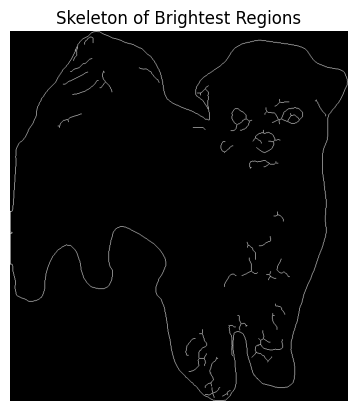

In [41]:
plt.imshow(combined, cmap='gray')
plt.title("Skeleton of Brightest Regions")
plt.axis('off')
plt.show()

plt.imsave("sk_mask.png", combined, cmap='gray')

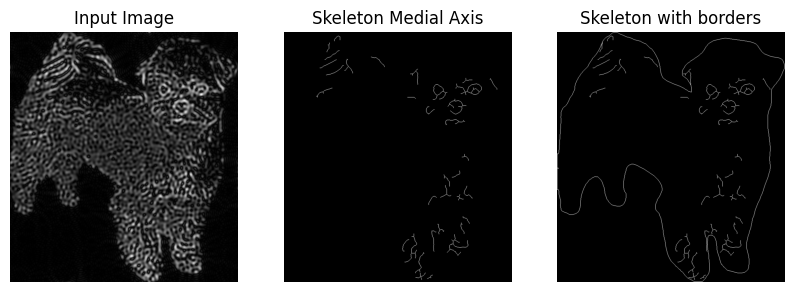

In [43]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Skeleton Medial Axis")
plt.imshow(skeleton_ma, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Skeleton with borders")
plt.imshow(combined, cmap='gray')
plt.axis('off')

# Length Estimation

In [59]:
coords = np.column_stack(np.where(combined > 0))
length_px = len(coords)

round(length_px, 3)

4878

In [45]:
def pixels_to_cm(pixels, reference_cm=10, reference_pixels=255):
  return round(pixels * (reference_cm / reference_pixels), 4)

In [60]:
pixels_to_cm(length_px)

191.2941

# Warp into a function

In [47]:
# export
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.morphology import binary_closing, binary_opening, disk, remove_small_objects
from skimage.morphology import medial_axis
from skimage.util import invert

In [ ]:
# export

def generate_bright_mask(img, threshold_percentile=90):
    '''
    Generate a binary mask of the brightest regions in a grayscale image.
    '''
    if img.max() <= 1:
        img = (img * 255).astype(np.uint8)
    else:
        img = img.astype(np.uint8)

    flat_vals = img[img > 0].flatten()

    threshold_val = np.percentile(flat_vals, threshold_percentile)

    _, bright_mask = cv2.threshold(img, int(threshold_val), 1, cv2.THRESH_BINARY)
    bright_mask = (bright_mask > 0).astype(np.uint8)

    # Closing the holes
    bright_mask = binary_closing(bright_mask, disk(2))
    bright_mask = binary_opening(bright_mask, disk(2))
    bright_mask = remove_small_objects(bright_mask.astype(bool), min_size=200).astype(np.uint8)

    return bright_mask

In [ ]:
# export

def medial_axis_skeleton(binary_image):
    """
    Compute skeleton preserving distance info using medial axis.
    Returns binary skeleton and distance map.
    """

    skel, dist = medial_axis(binary_image, return_distance=True)
    skel = skel.astype(np.uint8) * 255

    return skel

In [ ]:
# export

def combine_axis_skeleton(mask, skeleton):

  _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

  contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  border_image = np.zeros_like(binary_mask)

  cv2.drawContours(border_image, contours, -1, (255, 255, 255), 1)

  result = cv2.bitwise_or(skeleton, border_image)

  return result

In [56]:
def get_length_estimate(img_path, mask_path, threshold_percentile=90):

  img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

  brg_mask = generate_bright_mask(img, threshold_percentile)
  skeleton_ma = medial_axis_skeleton(brg_mask)
  combined = combine_axis_skeleton(mask, skeleton_ma)

  coords = np.column_stack(np.where(combined > 0))
  length_px = len(coords)

  return round(length_px, 3)

In [57]:
l = get_length_estimate("/content/img_back.png", "/content/character_mask.png")

In [58]:
pixels_to_cm(l)

190.7843